# Clustering con DBSCAN en Spark

# Contexto (el texto es de GPT, lo dejo ahí para tomar ideas)

El algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es especialmente útil cuando se desea identificar agrupaciones naturales en los datos sin asumir un número predeterminado de clusters y siendo robusto frente a ruido o valores atípicos. En el contexto de un dataset de canciones de Spotify, que contiene atributos como danceability, energy, valence, tempo, loudness, acousticness, instrumentalness, entre otros, DBSCAN puede ofrecer ventajas significativas para tareas de análisis musical y recomendaciones.

Posibles aplicaciones del clustering con DBSCAN en Spotify:

    Descubrimiento de géneros o subgéneros emergentes
    DBSCAN puede identificar grupos densos de canciones con características similares que no encajan bien en los géneros tradicionales. Esto permite detectar subgéneros o estilos musicales emergentes que aún no están bien definidos.

    Agrupamiento de canciones similares para sistemas de recomendación
    En lugar de basarse solo en colaborative filtering o clasificación supervisada, DBSCAN permite crear clusters de canciones similares en base puramente a sus características sonoras. Esto facilita recomendaciones más personalizadas y con base en el contenido musical real.

    Segmentación de playlists o análisis de tendencias musicales
    Se pueden analizar las playlists populares y agrupar canciones según su perfil acústico, revelando patrones dentro de géneros, subgéneros o estados de ánimo predominantes en diferentes momentos del tiempo.

    Identificación de canciones "outliers" o únicas
    Dado que DBSCAN clasifica algunos puntos como ruido, esto permite detectar canciones que se alejan notablemente de cualquier agrupación densa, lo cual puede ser útil para:

        Detectar música experimental.

        Identificar "joyas ocultas" con características inusuales.

        Filtrar outliers en análisis estadísticos.

Interés de una implementación paralela de DBSCAN en este contexto

El dataset de Spotify puede contener millones de canciones, lo que hace que una implementación secuencial de DBSCAN sea poco escalable debido a su alto coste computacional en el cálculo de distancias entre puntos. Una versión paralela distribuida con Apache Spark permite:

    Procesar grandes volúmenes de datos musicales en clústeres de computación.

    Reducir drásticamente el tiempo de ejecución al dividir el espacio musical en particiones.

    Mantener la precisión del algoritmo adaptando particiones con solapamiento (por el valor de eps) para no perder conexiones entre canciones similares en distintas regiones del espacio.

# Objetivos

# Descripción del algoritmo

## Clustering

https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d/

In [1]:
import os
import math
import numpy as np
import pyspark.sql.functions as sql_f

from graphframes import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from scipy.spatial import distance
from pyspark.sql.functions import col, substring
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import substring
from pyspark.sql.functions import size, col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import Row
from itertools import combinations

# Variable de entorno. Modificar en caso de disponer de varias
# versiones de Java instaladas.
os.environ["JAVA_HOME"] = r"/home/cristhian/Descargas/OpenJDK8U-jdk_x64_linux_hotspot_8u452b09/jdk8u452-b09"
os.environ["LD_LIBRARY_PATH"] = r"/usr/lib64"
os.environ["JAVA_OPTS"]=r"-Dcom.github.fommil.netlib.BLAS=com.github.fommil.netlib.NativeSystemBLAS -Dcom.github.fommil.netlib.LAPACK=com.github.fommil.netlib.NativeSystemLAPACK"

In [2]:
# Definición del entorno de ejecución
CORES = 6 # Número de núcleos de CPU a usar
PARTS = 6 # Número de particiones del dataset (para hacer repartition)
FRAC = 0.5 # Fracción de los datos aleatoriamente seleccionados
DIMS = 14  # Número de componentes PCA seleccionadas en base a mayor varianza explicada

spark = (
    SparkSession.builder.master(f"local[{CORES}]")
    .appName(f"Local DT con {CORES} particiones")
    .config("spark.driver.memory", "24g")
    .config("spark.executor.memory", "24g")
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

    .getOrCreate()
)
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/graphframes-checkpoints")

:: loading settings :: url = jar:file:/home/cristhian/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/cristhian/.ivy2/cache
The jars for the packages stored in: /home/cristhian/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cb44c5cf-15a0-4d5e-9ebd-e349b7fc96ff;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 86ms :: artifacts dl 2ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------

## Análisis

Explicar muy bien que podemos hacer el EDA con sklearn, ya que en principio (en la mayoría de dataset para Big Data) deberíamos hacer un sampling para poder hacerlo.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("spotify_songs.csv")

print("Tamaño: ", data.shape)
print(data.head())

Tamaño:  (32833, 23)
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Just

In [4]:
print("Variables y sus tipos")
print(data.info())

Variables y sus tipos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-nul

In [5]:
print("Resumen estadístico:")
print(data.describe())

Resumen estadístico:
       track_popularity  danceability        energy           key  \
count      32833.000000  32833.000000  32833.000000  32833.000000   
mean          42.477081      0.654850      0.698619      5.374471   
std           24.984074      0.145085      0.180910      3.611657   
min            0.000000      0.000000      0.000175      0.000000   
25%           24.000000      0.563000      0.581000      2.000000   
50%           45.000000      0.672000      0.721000      6.000000   
75%           62.000000      0.761000      0.840000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  32833.000000  32833.000000  32833.000000  32833.000000   
mean      -6.719499      0.565711      0.107068      0.175334   
std        2.988436      0.495671      0.101314      0.219633   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -8.171000      0.0000

In [6]:
print("Número de valores nulos:")
print(data.isnull().sum())

Número de valores nulos:
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64


Distribución variables numéricas:


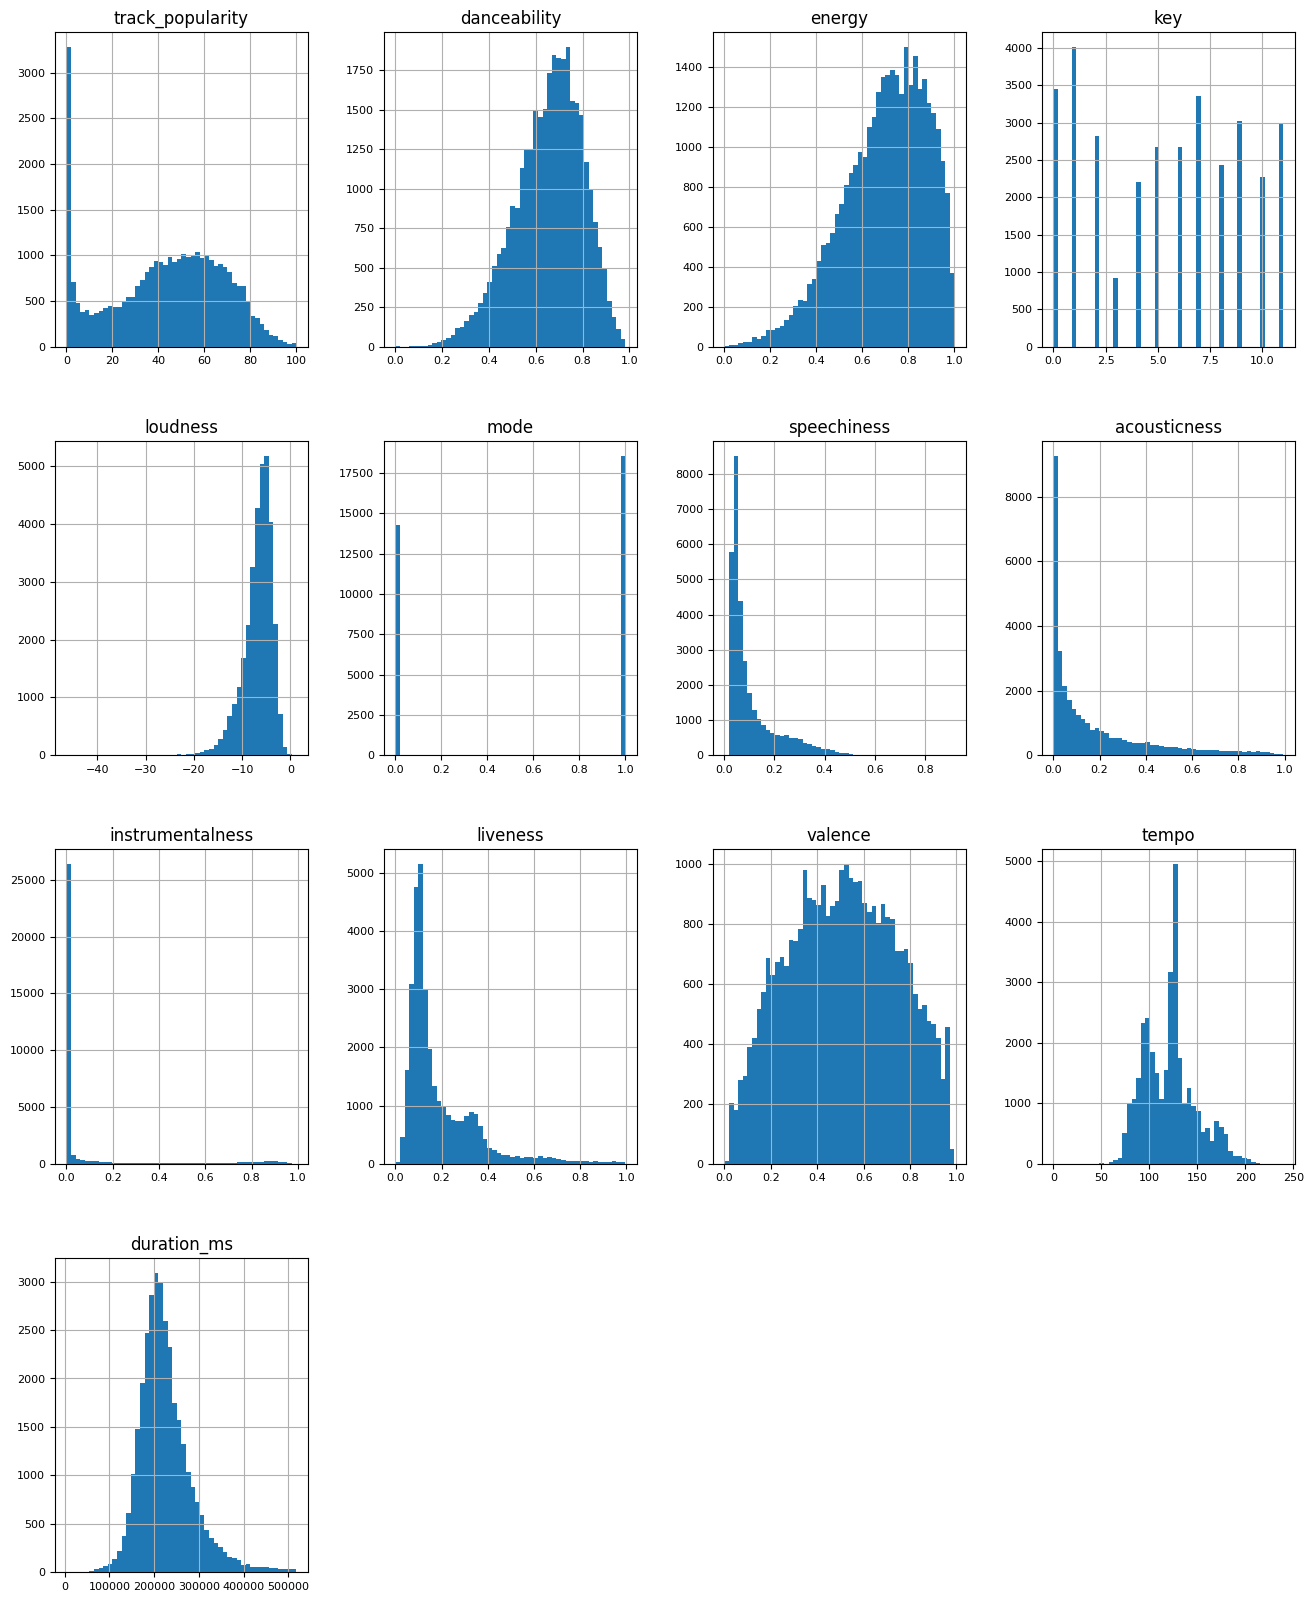

In [7]:
print("Distribución variables numéricas:")
data_num = data.select_dtypes(include = ['int64', 'float64'])
data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [8]:
print("Variables categóricas:")
data_cat = data.select_dtypes(include = ['object'])
print(data_cat.columns)

Variables categóricas:
Index(['track_id', 'track_name', 'track_artist', 'track_album_id',
       'track_album_name', 'track_album_release_date', 'playlist_name',
       'playlist_id', 'playlist_genre', 'playlist_subgenre'],
      dtype='object')


playlist_genre
edm      6043
latin    5155
pop      5507
r&b      5431
rap      5746
rock     4951
dtype: int64
playlist_genre  playlist_subgenre        
edm             big room                     1206
                electro house                1511
                pop edm                      1517
                progressive electro house    1809
latin           latin hip hop                1656
                latin pop                    1262
                reggaeton                     949
                tropical                     1288
pop             dance pop                    1298
                electropop                   1408
                indie poptimism              1672
                post-teen pop                1129
r&b             hip pop                      1256
                neo soul                     1637
                new jack swing               1133
                urban contemporary           1405
rap             gangster rap                 1

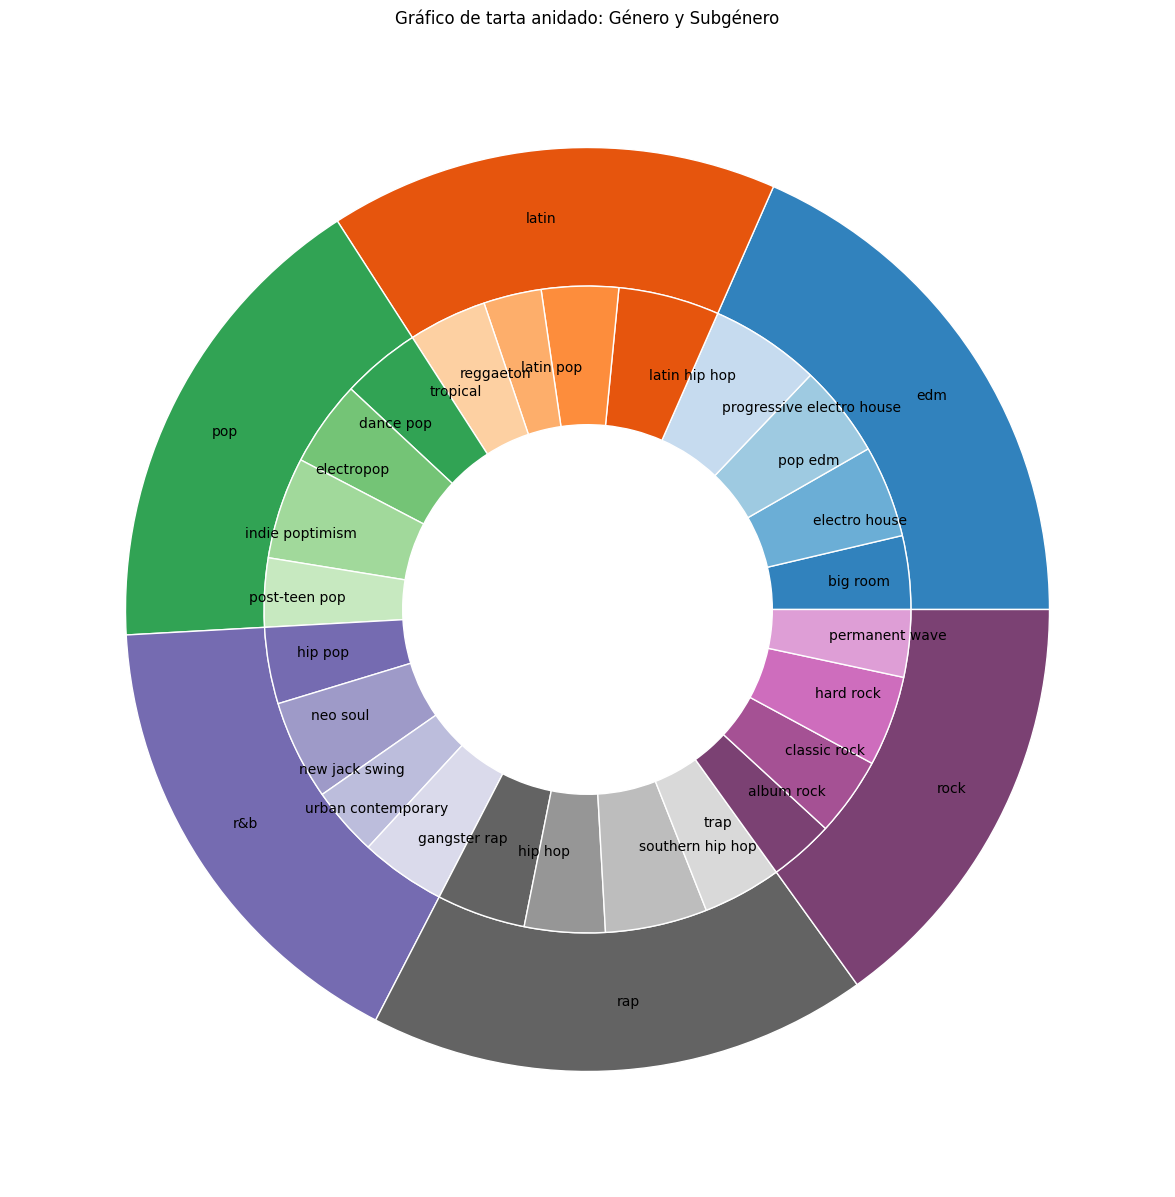

In [9]:
# 1. Agrupar por 'playlist_genre' para la capa externa y contar la cantidad de registros por género.
outer_data = data.groupby('playlist_genre').size()
print(outer_data)

# 2. Agrupar por ambas variables para la capa interna y contar la cantidad de registros por cada combinación de género y subgénero.
inner_data = data.groupby(['playlist_genre', 'playlist_subgenre']).size()
print(inner_data)

# Preparar los datos para el gráfico:
# Etiquetas y tamaños para la tarta externa (por géneros)
outer_labels = outer_data.index.tolist()
outer_sizes = outer_data.values.tolist()

# Para la tarta interna (por subgéneros) se requiere mantener el orden para asignar colores coherentes.
inner_labels = []
inner_sizes = []
# Definiremos una lista de colores para la tarta interna basados en un colormap.
colors_inner = []

# Usamos un colormap de matplotlib  para obtener colores diferenciados.
cmap = plt.get_cmap('tab20c')
cmap2 = plt.get_cmap('tab20b')
# Para la asignación de colores, definimos un índice que se irá incrementando a medida que agregamos subcategorías.
color_idx = 0

# Recorremos cada género para extraer sus subgéneros
for genre in outer_labels:
    # Seleccionar los datos del género actual
    sub_data = inner_data[genre]
    # Agregar las etiquetas de subgénero y sus cantidades
    for subgenre, count in sub_data.items():
        inner_labels.append(subgenre)
        inner_sizes.append(count)
        # Asignar un color del colormap (se puede ajustar la estrategia de asignación si se desea)
        if (color_idx < 20):
            colors_inner.append(cmap(color_idx))
        else:
            colors_inner.append(cmap2(color_idx-4))
        color_idx += 1
# Crear el gráfico
fig, ax = plt.subplots(figsize=(15, 15))

colors_outer = [cmap(i*4) for i in range(5)]
colors_outer.append(colors_inner[-4])
print(colors_outer)
# Capa externa: gráfico de tarta de géneros.
# Usamos 'wedgeprops' para definir el ancho de las "donut slices".
ax.pie(outer_sizes, radius=1, labels=outer_labels, labeldistance=0.85,
       colors=colors_outer, wedgeprops=dict(width=0.3, edgecolor='white'))

# Capa interna: gráfico de tarta de subgéneros.
# Se dibuja sobre la capa externa.
ax.pie(inner_sizes, radius=1-0.3, labels=inner_labels, labeldistance=0.75,
       colors=colors_inner, wedgeprops=dict(width=0.3, edgecolor='white'))

# Asegurar que el gráfico tiene relación de aspecto 1:1 para que sea circular.
ax.set(aspect="equal")
plt.title("Gráfico de tarta anidado: Género y Subgénero")
plt.show()

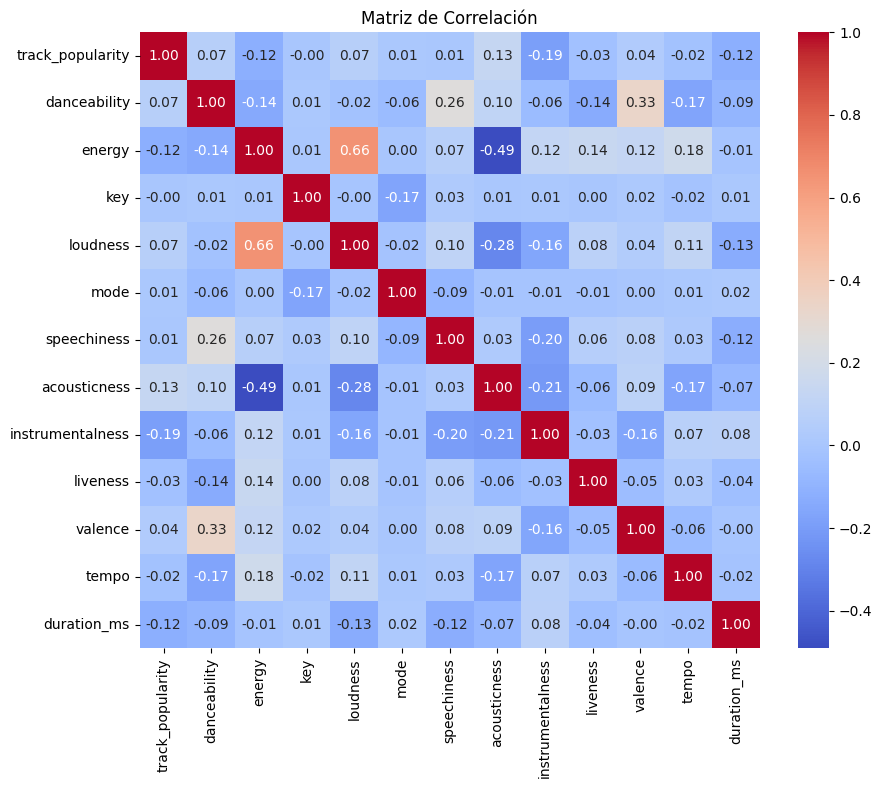

In [10]:
# Spearman
corr_matrix = data_num.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

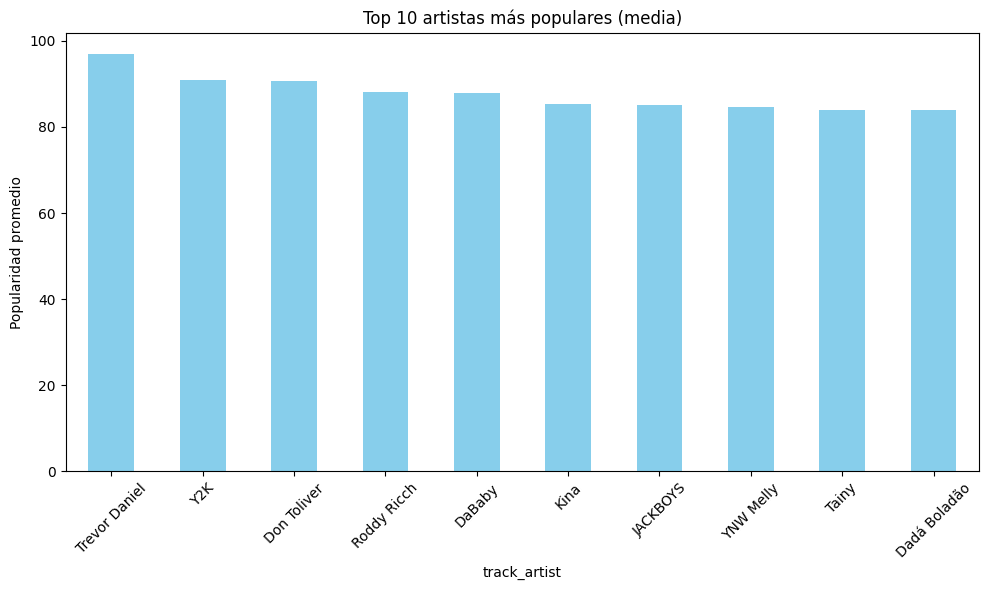

In [11]:
top_artistas = data.groupby('track_artist')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_artistas.plot(kind='bar', color='skyblue')
plt.title('Top 10 artistas más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

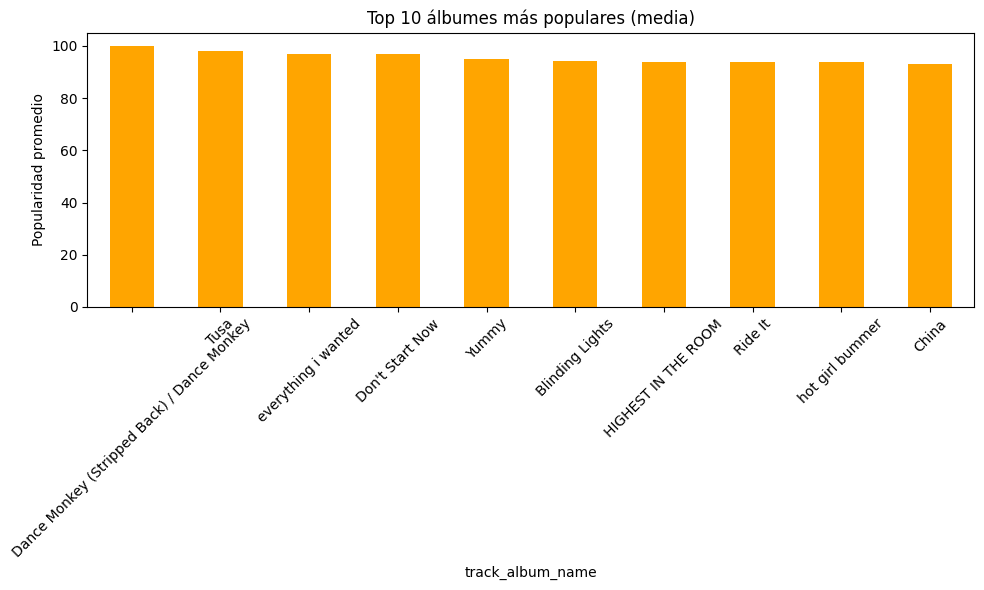

In [12]:
top_albums = data.groupby('track_album_name')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_albums.plot(kind='bar', color='orange')
plt.title('Top 10 álbumes más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


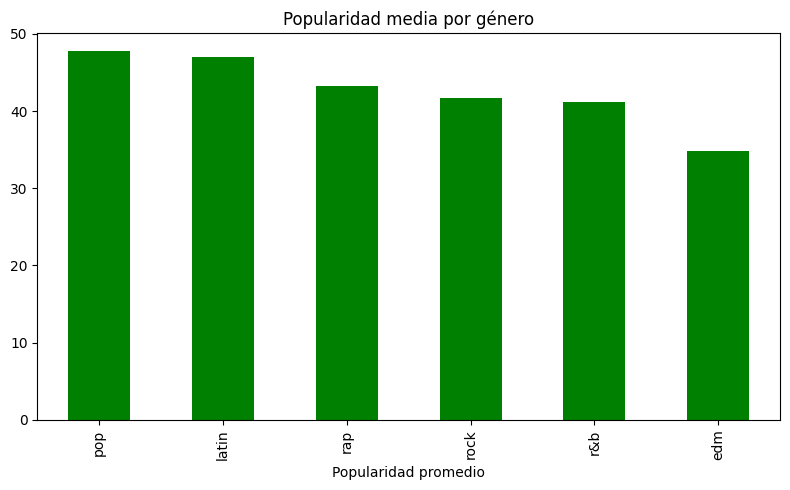

In [13]:
top_generos = data.groupby('playlist_genre')['track_popularity'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
top_generos.plot(kind='bar', color='green')
plt.title('Popularidad media por género')
plt.xlabel('Popularidad promedio')
plt.tight_layout()
plt.show()


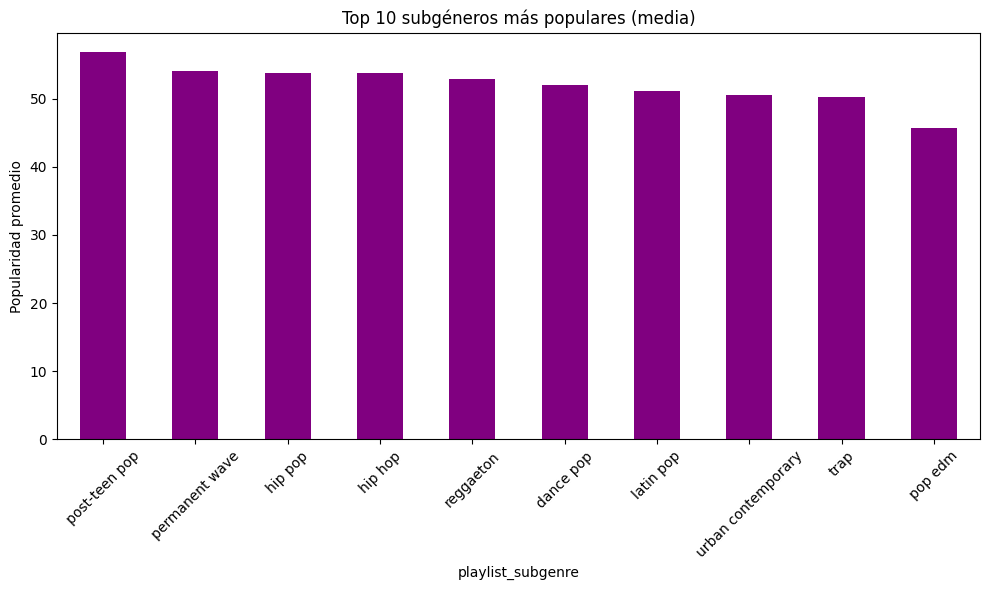

In [14]:
top_subgeneros = data.groupby('playlist_subgenre')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_subgeneros.plot(kind='bar', color='purple')
plt.title('Top 10 subgéneros más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Carga de datos con Spark

Tras realizar un análisis exploratorio de datos con Pandas y  librerías estándar para el visualizado, pasamos a trabajar en la problemática de Big Data que tiene el problema, comenzamos desde este punto a usar la tecnología Spark.

Comenzamos leyendo el conjunto de datos desde el archivo en formato csv que tenemos. Utilizando la función read() y algunas de sus funciones internas podemos especificar el formato de origen del archivo, si queremos que se incluya la cabecera o no (en nuestro caso, la incluiremos), el delimitador que existe en el archivo original para dividir los diferentes valores de un individuo (en nuestro caso, una coma), cargamos el archivo y con repartition indicamos a Spark, en la cantidad de particiones que queremos que distribuya los datos.

In [15]:
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('delimiter', ',') \
    .load('spotify_songs.csv') \
    .repartition(PARTS)

Mostramos los 10 primeros individuos del conjunto de datos. Observamos como la carga se ha completado, en principio, sin ningún problema aparente ni en los individuos ni en los atributos.

In [16]:
df.show(10, truncate=False) 

+----------------------+--------------------------------------+---------------+----------------+----------------------+--------------------------------------+------------------------+---------------------+----------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|track_id              |track_name                            |track_artist   |track_popularity|track_album_id        |track_album_name                      |track_album_release_date|playlist_name        |playlist_id           |playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|
+----------------------+--------------------------------------+---------------+----------------+----------------------+--------------------------------------+------------------------+---------------------+----------------------+--------------

Mostramos los nombres de los atributos y su tipo, imprimiendo el esquema del dataframe. Observamos como por defecto todos los atributos se cargan con tipo de dato String. Será necesaria más tarde una conversión de alguno de ellos a un tipo numérico. 

In [17]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: string (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: string (nullable = true)



A modo de comprobación, tras observar en el EDA los valores únicos de ciertas variables, comprobamos si se siguen cumpliendo tras la lectura de los datos en Spark.

In [18]:
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select('playlist_genre').distinct().count())

+--------------------+
|      playlist_genre|
+--------------------+
|                 r&b|
|                 pop|
|                 edm|
|                 rap|
|48AzM7l4M02DBYd2N...|
|                rock|
|0JmBB9HfrzDiZoPVR...|
|               latin|
|1E5VdGGWkpDQ682gd...|
| Matthias Heilbro...|
|4425cRh83Uzor4qCR...|
|6wyJ4bsjZaUKa9f6G...|
|37i9dQZF1DWTDafB3...|
|5EMARioe9z9eKOeWI...|
+--------------------+

Número de géneros únicos: 14


Observamos como tenemos para la variable playlist_genre algunos valores inesperados, tras revisar el conjunto de datos observamos algunos individuos en el conjuntos de datos que tienen valores erróneos. En la siguiente sección, el preprocesado, lidiamos con este problema. 

# Preprocesado

En esta sección llevamos a cabo el preprocesado del trabajo utilizando Spark. De forma resumida, en esta parte, realizamos las siguientes tareas: asignar los tipos correctos a las variables, filtrar algunos individuos para solucionar la existencia de individuos con valores corruptos, la eliminación de variables con un valor único para cada individuo (variables identificadoras del individuo), aplicación de one-hot encoding para permitir la inclusión de variables categóricas y la aplicación de reducción de dimensionalidad via PCA. 

Importamos algunas dependencias generales para el trabajo.

In [19]:
# Dependencias generales
import matplotlib.pyplot as plt
import numpy as np


from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

## Asignación de los tipos correctos de las variables 

Algunas variables como track_popularity (que mide la popularidad) y danceability (que mide cómo de bailable es una canción) entre muchas otras, tienen una naturaleza numérica.  Para ello, definimos una lista con los nombres de las columnas del DataFrame df, de las cuales queremos convertir su tipo.  A partir de aquí, realizamos un casting al tipo de dato DoubleType (números decimales) mediante un bucle.

In [20]:
# Lista de columnas a convertir
cols_to_convert = [
    "track_popularity", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
    "tempo", "duration_ms"
]

# Castea las columnas especificadas a DoubleType
for c in cols_to_convert:
    df = df.withColumn(c, col(c).cast(DoubleType()))

Observamos de nuevo el esquema de DataFrame donde ahora sí comprobamos que están las variables con su tipo correcto.

In [21]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: double (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)



## Eliminación de instancias corruptas

Tras el análisis se han comprobado la existencia de ciertas instancias con valores corruptos en el conjunto de datos. Proponemos una solución directa, que en el contexto de Big Data y nuestro dataset (que tiene una suficiente cantidad de individuos) vemos viable y razonable: la eliminación directa. Para ello, se filtran únicamente las instancias que cumplen con alguno de los posibles valores de la variable categórica: playlist_genre (vista en el análisis). 

Utilizamos la construcción de una lista manual de los valores correctos y la función filter() para su correcto filtrado.

In [22]:
from pyspark.sql.functions import col

valid_genres = ['pop', 'rock', 'rap', 'edm', 'r&b', 'latin']
df = df.filter(col('playlist_genre').isin(valid_genres))

In [23]:
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select('playlist_genre').distinct().count())

+--------------+
|playlist_genre|
+--------------+
|           r&b|
|           pop|
|           edm|
|           rap|
|          rock|
|         latin|
+--------------+

Número de géneros únicos: 6


A modo de comprobación, mostramos y contamos los valores únicos de esa variable para comprobar que ya no existen los valores erróneos que obteníamos antes. Ahora sí, tenemos los verdaderos valores y su verdadera cantidad. Como no hemos detectado ningunos otros valores erróneos, asumimos que se han filtrado el resto de valores correctamente, y ya tenemos el conjunto de datos limpio.

## Eliminación de variables con valores únicos 

Se eliminarán las variables que tienen un valor identificador para cada canción. Las variables como: track_id, track_name, track_artist, track_album_id, track_album_name, playlist_name y playlist_id son eliminadas en este apartado, porque actúan como identificadores únicos y no aportan valor predictivo ni patrones útiles al análisis; al tener un valor distinto para cada fila, no permiten generalización, pueden introducir ruido y aumentarían la complejidad del modelo sin beneficio real.

In [24]:
cols_to_drop = [
    'track_id', 'track_name', 'track_artist', 
    'track_album_id', 'track_album_name', 
    'playlist_name', 'playlist_id'
]

df = df.drop(*cols_to_drop)

## Inclusión de un ID propio

A pesar de haber eliminado las variables identificadoras como track_id o track_name, se incluirá una variable id (de construcción propia) que no será utilizada en el algoritmo de clustering, pero que servirá como referencia para realizar visualizaciones pertinentes. Esta variable nos permitirá vincular cada observación con sus valores originales de las variables categóricas playlist_genre y playlist_subgenre, facilitando así la interpretación y comparación de los resultados obtenidos por el clustering con las categorías iniciales de las playlists.

Para ello, utilizamos la función monotonically_increasing_id. Esta función genera valores enteros largos que aumentan de forma monótona, aunque no necesariamente consecutiva ni ordenada estrictamente, lo que garantiza unicidad sin necesidad de una columna de índice previamente definida. 

In [25]:
from pyspark.sql.functions import monotonically_increasing_id

# Añadimos la ID al comienzo de la línea
df = df.withColumn("id", monotonically_increasing_id())

In [26]:
df.show()

+----------------+------------------------+--------------+-----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+
|track_popularity|track_album_release_date|playlist_genre|playlist_subgenre|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms| id|
+----------------+------------------------+--------------+-----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+
|            72.0|              2010-11-22|           pop|    post-teen pop|       0.813| 0.627|11.0|  -5.018| 0.0|     0.0486|       0.076|         6.16E-4|   0.131|  0.801|130.011|   195853.0|  0|
|            69.0|              2019-06-07|           rap|          hip hop|       0.951| 0.573| 0.0|  -6.002| 0.0|      0.227|      0.0667|             0.0|   0.119|   0.42|105.052|   211040.0|  1|
|    

## Aplicación de one-hot enconding de las variables categóricas

Se aplicará one-hot enconding a las variables: playlist_genre, playlist_subgenre. Y a la variable: track_album_release_date se le aplica un one-hot encoding por decada.

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

def one_hot_preprocess(df, categorical_cols):

    indexers = [StringIndexer(inputCol=col, outputCol=col + '_idx', handleInvalid='keep') for col in categorical_cols]
    encoders = [OneHotEncoder(inputCol=col + '_idx', outputCol=col + '_ohe') for col in categorical_cols]

    pipeline = Pipeline(stages=indexers + encoders)
    return  pipeline.fit(df).transform(df)

In [28]:
categorical_cols = ['playlist_genre']
df = one_hot_preprocess(df, categorical_cols= categorical_cols)

In [29]:
df.select('playlist_genre', 'playlist_genre_ohe').show(10, truncate=False)

+--------------+------------------+
|playlist_genre|playlist_genre_ohe|
+--------------+------------------+
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
+--------------+------------------+
only showing top 10 rows



In [30]:
from pyspark.sql.functions import substring

# Extraer el año de la fecha (formato 'YYYY-MM-DD')
df = df.withColumn("release_year", substring("track_album_release_date", 1, 4).cast("int")).cache()

In [31]:
# Guardamos las variables 'playlist_genre' y 'playlist_subgenre' en otro dataframe
# Nota: serán útiles más tarde para comparar con los resultados del Clustering
df_var_saved = df.select('id', 'playlist_genre', 'playlist_subgenre')

print(df.show())

# Eliminación de variables transformadas y retiradas
df = df.drop('playlist_genre', 'playlist_subgenre', 'track_album_release_date')

+----------------+------------------------+--------------+-----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------------+------------+
|track_popularity|track_album_release_date|playlist_genre|playlist_subgenre|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms| id|playlist_genre_idx|playlist_genre_ohe|release_year|
+----------------+------------------------+--------------+-----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------------+------------+
|            72.0|              2010-11-22|           pop|    post-teen pop|       0.813| 0.627|11.0|  -5.018| 0.0|     0.0486|       0.076|         6.16E-4|   0.131|  0.801|130.011|   195853.0|  0|               2.0|     (6,[2],[1.0])|        2010|


In [32]:
# Mostramos variables guardadas
df_var_saved.show(truncate=False)

+---+--------------+-----------------+
|id |playlist_genre|playlist_subgenre|
+---+--------------+-----------------+
|0  |pop           |post-teen pop    |
|1  |rap           |hip hop          |
|2  |rap           |trap             |
|3  |pop           |electropop       |
|4  |rock          |hard rock        |
|5  |rock          |permanent wave   |
|6  |rock          |permanent wave   |
|7  |rock          |album rock       |
|8  |rock          |classic rock     |
|9  |rock          |album rock       |
|10 |rap           |trap             |
|11 |pop           |indie poptimism  |
|12 |rock          |classic rock     |
|13 |pop           |post-teen pop    |
|14 |rock          |permanent wave   |
|15 |rock          |classic rock     |
|16 |rap           |gangster rap     |
|17 |rap           |hip hop          |
|18 |rap           |hip hop          |
|19 |rap           |southern hip hop |
+---+--------------+-----------------+
only showing top 20 rows



In [33]:
idx_cols = [col + '_idx' for col in categorical_cols]
df = df.drop(*idx_cols)

In [34]:
df.show(20, truncate=False)

+----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+
|track_popularity|danceability|energy|key |loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|
+----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+
|72.0            |0.813       |0.627 |11.0|-5.018  |0.0 |0.0486     |0.076       |6.16E-4         |0.131   |0.801  |130.011|195853.0   |0  |(6,[2],[1.0])     |2010        |
|69.0            |0.951       |0.573 |0.0 |-6.002  |0.0 |0.227      |0.0667      |0.0             |0.119   |0.42   |105.052|211040.0   |1  |(6,[1],[1.0])     |2019        |
|47.0            |0.367       |0.645 |11.0|-6.432  |0.0 |0.0408     |0.189       |0.0             |0.105   |0.0742 |149.955|262400.0   

### Modificar la representación de one-hot Sparse Vector a columnas convencionales 

Explicar muy bien porque hemos pensado en cierto punto de la implemetación cambiar a columnas convencionales.

## Estandarización

In [35]:
columnas = df.columns

if "id" in columnas:
    columnas.remove("id")

In [36]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Ensamblar todas los atributos en un único vector dentro de una sola columna
assembler = VectorAssembler(inputCols=columnas, outputCol="features")
df = assembler.transform(df)

# Ajuste de la estandarización
scaler = StandardScaler(
    inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Eliminar la columna 'features'
df = df.drop('features')

df.show(20, truncate=False)

25/04/25 04:54:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key |loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|scaled_features                                                                                                                                                                                                                                             

## Aplicación de reducción de la dimensionalidad

### Análisis de la varianza explicada de las componentes

In [37]:
from pyspark.ml.feature import PCA

# Obtener el tamaño del vector en la columna 'features'
vector_size = df.select("scaled_features").first()[0].size

pca = PCA(k = vector_size, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

25/04/25 04:54:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/25 04:54:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
25/04/25 04:54:36 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/04/25 04:54:36 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


[0.12425651 0.23617776 0.32277568 0.39915552 0.46728501 0.5270107
 0.58343955 0.63857329 0.68729757 0.73344538 0.77645893 0.81722258
 0.8578004  0.89051726 0.92105821 0.95006117 0.97077572 0.98966445
 1.         1.        ]


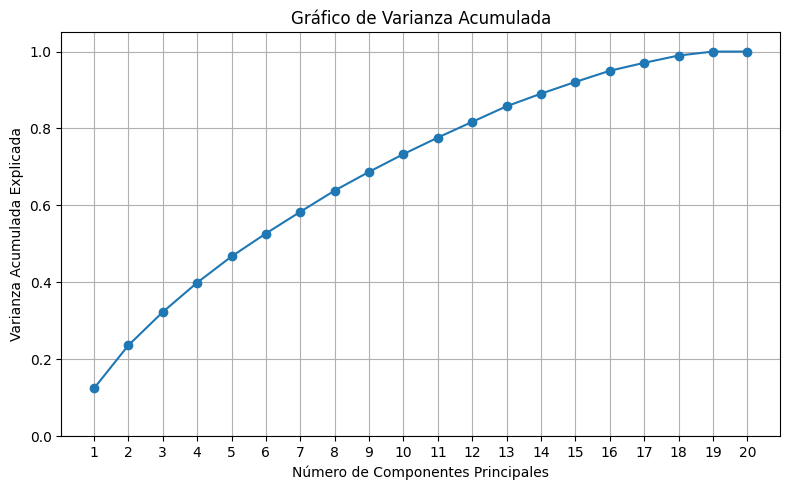

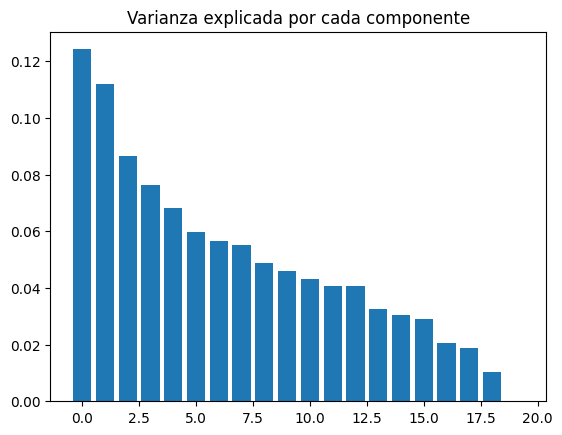

In [38]:
explained_variance = pca_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

# Visualizar varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Gráfico de Varianza Acumulada')
plt.grid(True)
plt.ylim(0, 1.05)
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.tight_layout()
plt.show()

# Visualizar varianza explicada por cada componente
plt.bar(range(explained_variance.shape[0]), explained_variance/np.sum(explained_variance))
plt.title('Varianza explicada por cada componente')
plt.show()

### Reducción de la dimensionalidad con PCA

In [39]:
# Cantidad de componentes principales a conservar

# Ajustar el modelo de PCA
pca = PCA(k = DIMS, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

# Transformar el dataframe
df = pca_model.transform(df)

# Eliminar la variable de 'scaled_features'
pca_data = df.drop('scaled_features')

In [40]:
pca_data.show(20, truncate=False)

+----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key |loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|pca_features                                                                                                                                                                                                                                                                           |
+----------------+------------+------+----+--------+----+-----------+------------+------------

# Hola - Esto deberíamos moverlo arriba para seguir con el esquema que se espera del notebook :)

    Contexto
    Objetivos
    Descripción detallada de la soluciones propuestas  <--- Poner aquí
        Breve discusión de las decisiones clave que hacen que tu algoritmo sea escalable
    Experimentos
        Estudio breve de escalabilidad (scale-up, size-up, speedup)
        Resultados acorde a métricas relevantes
    Discusión de resultados
    Resumen de la contribución de cada miembro del equipo

In [ ]:
from pyspark.sql.functions import col, floor, sqrt, collect_set
from pyspark.ml.functions import vector_to_array
from graphframes import GraphFrame
from itertools import combinations


def euclidean_distance_expr(vec1, vec2, dim):
    return sqrt(sum([(vec1[i] - vec2[i]) ** 2 for i in range(dim)]))


def process_dataframe(spark, df, epsilon, min_pts, dim, checkpoint_dir):
    # Convertimos el vector a array para poder acceder a los valores
    df = df.withColumn("value_array", vector_to_array(col("value")))

    # Seleccionamos un pivote aleatorio
    pivot_vector = df.select("value_array").limit(1).collect()[0][0]

    # Calcular la distancia al pivote y asignar particiones
    dist_expr = sum([
        (col("value_array")[i] - float(pivot_vector[i])) ** 2 for i in range(dim)
    ])
    df = df.withColumn("pivot_dist", sqrt(dist_expr)) \
           .withColumn("partition", floor(col("pivot_dist") / epsilon).cast("int"))

    # Alias para join consigo mismo
    df_a = df.alias("a")
    df_b = df.alias("b")

    # Join por partición y evitando duplicados (id_a < id_b)
    df_pairs = df_a.join(df_b, (col("a.partition") == col(
        "b.partition")) & (col("a.id") < col("b.id")))

    # Calcular distancia y filtrar vecinos
    df_pairs = df_pairs.withColumn(
        "distance",
        euclidean_distance_expr(col("a.value_array"),
                                col("b.value_array"), dim)
    )

    df_neighbors = df_pairs.filter(col("distance") < epsilon) \
        .select(col("a.id").alias("src"), col("b.id").alias("dst"))

    # Agrupar vecinos por punto
    adjacency = df_neighbors.groupBy("src").agg(
        collect_set("dst").alias("neighbors"))

    # Etiquetar núcleos y puntos base
    def label_points(row):
        id = row["src"]
        neighbors = row["neighbors"]
        if len(neighbors) + 1 >= min_pts:
            out = [(id, (id, True))]
            out.extend([(n, (id, False)) for n in neighbors])
            return out
        else:
            return []

    labeled_rdd = adjacency.rdd.flatMap(label_points)

    # Combinar etiquetas por punto
    def combine_labels(x):
        point, tags = x
        core = any(tag[1] for tag in tags)
        clusters = [tag[0] for tag in tags]
        return point, clusters if core else [clusters[0]], core

    combined = labeled_rdd.groupByKey().mapValues(list).map(combine_labels).cache()

    df_initial = combined.map(lambda x: (x[0], x[1][0], x[2])) \
        .toDF(["point", "cluster_label", "core_point"])

    vertices = combined.flatMap(
        lambda x: [(cid,) for cid in x[1]]).distinct().toDF(["id"])

    edges = combined.flatMap(lambda x: combinations(x[1], 2)) \
        .map(lambda x: (x[0], x[1])) \
        .distinct().toDF(["src", "dst"])

    spark.sparkContext.setCheckpointDir(checkpoint_dir)
    g = GraphFrame(vertices, edges)
    components = g.connectedComponents()

    result = df_initial.join(components, df_initial.cluster_label == components.id) \
                       .select("point", "component", "core_point")

    return result

In [ ]:
df_pca = pca_data.select("id", "pca_features")
df_preproc = df_pca.sample(withReplacement=False, fraction=FRAC, seed=123456)

# Renombramos la columna por un nombre genérico como value
df_preproc = df_preproc.withColumnRenamed("pca_features", "value").cache()

# Mostrar el resultado
df_preproc.show(5, truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |value                                                                                                                                                                                                                                                                                  |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1  |[-0.4970137739931457,2.6596176960994304,-0.3841709310882495,-1.3936637880427913,0.9432916386457862,-0.3449971333831889,0.8476041109300735

In [43]:
# Ejecución del algoritmo
from pyspark.sql import functions as F
EPSILON = 2.3
MINPTS = 20


# Distancia en 1D
def dist_spark(c1, c2): return F.abs(c1 - c2)


# df_clusters = process_dataframe(spark, df_preproc, EPSILON, MINPTS, 14, "checkpoints")

In [44]:
import time
n=1
tiempos = 0
for i in range(n):
    start = time.perf_counter()
    df_clusters = process_dataframe(
        spark, df_preproc, EPSILON, MINPTS, 14, "checkpoints")
    end = time.perf_counter()

    elapsed = (end - start)
    print(
        f"Duración ejecición {i} con {FRAC * 100}% datos: {elapsed}")

    tiempos += elapsed

print("Tiempo medio: ", tiempos/n)

25/04/25 04:54:42 WARN BlockManager: Task 127 already completed, not releasing lock for rdd_211_0


Duración ejecición 0 con 50.0% datos: 28.401775136999277
Tiempo medio:  28.401775136999277


In [45]:
df_clusters.take(1)

[Row(point=2852, component=4, core_point=True)]

In [46]:
# Mostrar el resultado por cluster
df_counts = df_clusters.groupBy("component").count()
df_counts.show()

+---------+-----+
|component|count|
+---------+-----+
|     2940| 2121|
|      427|  102|
|       51| 2154|
|     2954| 2302|
|        1|   73|
|     3564|   64|
|     3038|  229|
|       10| 1854|
|     3112|  116|
|      982|   43|
|       11| 2239|
|     3014|   78|
|        4| 1161|
|      122|  590|
|     4444|   20|
|      398|   21|
+---------+-----+



In [47]:
df_joined = df_preproc.join(df_clusters, df_preproc.id == df_clusters.point, how="left")
df_joined = df_joined.na.fill({'component': -1})
df_results = df_joined.select("id", "value", "component").toPandas()

print(df_results.head(10))

     id                                              value  component
0   964  [-4.0693743890475025, -4.693163958764234, 0.37...         -1
1  1677  [-1.2351876902719054, 0.8095953849079731, -0.3...         10
2  2214  [1.6322896741262327, -2.1584176242398403, -0.7...          4
3  2250  [-0.28413866512860086, -0.5747332039949885, 0....         11
4  2453  [-2.046831929354459, -1.169123610385389, -0.06...          4
5  2509  [0.8721982847446966, 2.1178742549076617, -0.95...         10
6  2927  [0.4516625887120688, -2.2684870691234744, 0.67...         -1
7  3091  [-0.3201221924186668, 0.5155491191437017, -1.6...         51
8  3506  [3.0335797045298083, -0.4842184065126511, 2.44...       3038
9  4894  [0.7622049952987926, -1.1724484400863924, 0.39...         -1


In [48]:
from sklearn.manifold import TSNE

X = np.array(df_results['value'].tolist())

# Obtenemos descompisición TSNE de 2 componentes para representar
tsne = TSNE(n_components=2, random_state=123456, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

# Agregamos junto a PCA en el dataframe

df_results[['pca1', 'pca2']] = pd.DataFrame(
    df_results['value'].tolist(), index=df_results.index)[[0, 1]]
df_results['tsne1'] = X_tsne[:, 0]
df_results['tsne2'] = X_tsne[:, 1]
print(df_results.head(10))

     id                                              value  component  \
0   964  [-4.0693743890475025, -4.693163958764234, 0.37...         -1   
1  1677  [-1.2351876902719054, 0.8095953849079731, -0.3...         10   
2  2214  [1.6322896741262327, -2.1584176242398403, -0.7...          4   
3  2250  [-0.28413866512860086, -0.5747332039949885, 0....         11   
4  2453  [-2.046831929354459, -1.169123610385389, -0.06...          4   
5  2509  [0.8721982847446966, 2.1178742549076617, -0.95...         10   
6  2927  [0.4516625887120688, -2.2684870691234744, 0.67...         -1   
7  3091  [-0.3201221924186668, 0.5155491191437017, -1.6...         51   
8  3506  [3.0335797045298083, -0.4842184065126511, 2.44...       3038   
9  4894  [0.7622049952987926, -1.1724484400863924, 0.39...         -1   

       pca1      pca2      tsne1      tsne2  
0 -4.069374 -4.693164  51.848282   5.314388  
1 -1.235188  0.809595  56.248184  53.697746  
2  1.632290 -2.158418  56.336060 -27.459295  
3 -0.284139 

In [49]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_result(dataset, result_tags, file_name=None, style='ticks', title=""):

    # Preparamos los datos
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags

    # Ajustamos el formato
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    sns.scatterplot(x='x', y='y', data=df, ax=axes[0], color='blue')
    axes[0].set_title('Puntos sin etiquetar')

    # Añadimos los valores
    sns.scatterplot(x='x', y='y', data=df, hue='label',
                    ax=axes[1], palette='tab20')
    axes[1].set_title(title)

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    # Asignamos título
    if file_name:
        f.suptitle(title, fontsize=14)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()  # Para que no se corte el gráfico
    plt.show()

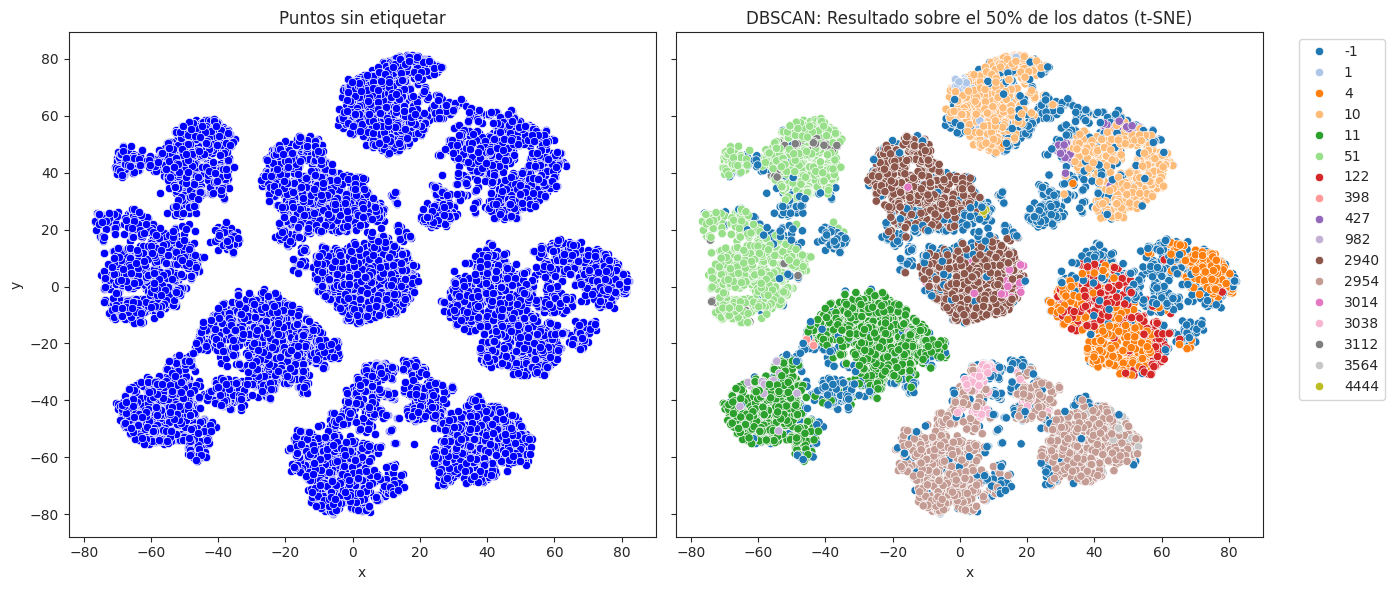

In [50]:
plot_result(X_tsne, df_results["component"], title="DBSCAN: Resultado sobre el 50% de los datos (t-SNE)")

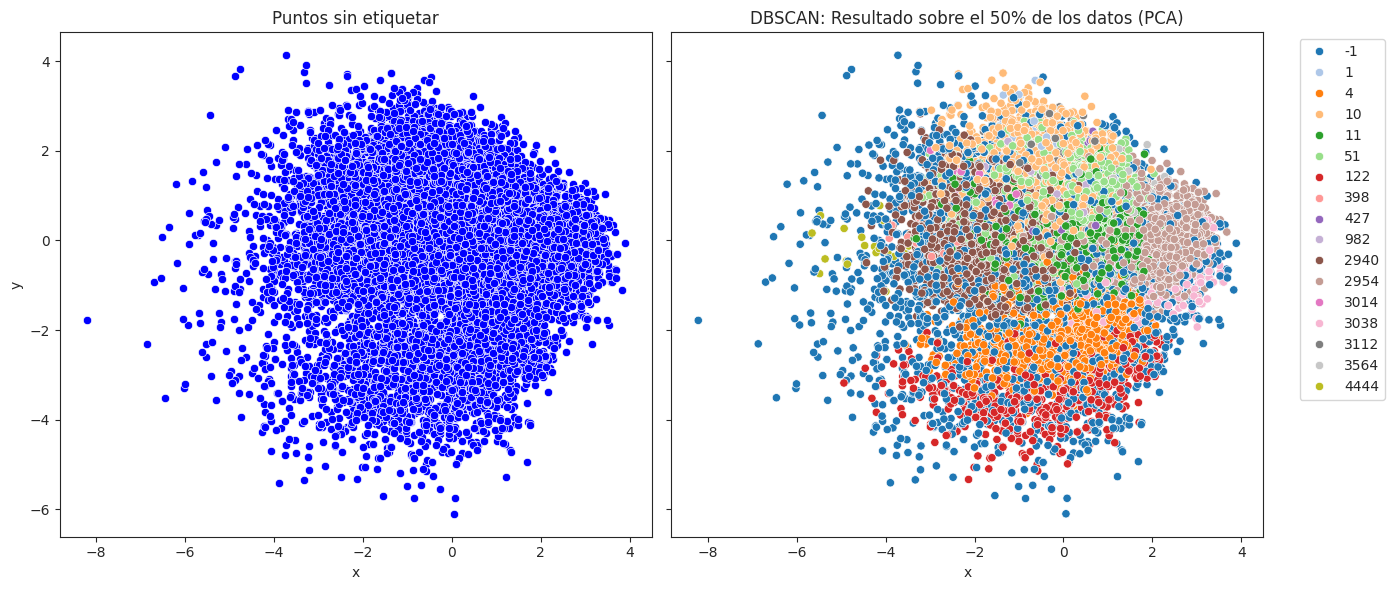

In [51]:
plot_result(df_results[['pca1', 'pca2']], df_results["component"], title="DBSCAN: Resultado sobre el 50% de los datos (PCA)")

In [52]:
df_subgeneros = df_var_saved.toPandas()
df_etiq_subgeneros = pd.merge(df_subgeneros, df_results, on='id')
print(df_etiq_subgeneros.head(5))

   id playlist_genre playlist_subgenre  \
0   1            rap           hip hop   
1   2            rap              trap   
2   3            pop        electropop   
3   4           rock         hard rock   
4   5           rock    permanent wave   

                                               value  component      pca1  \
0  [-0.4970137739931457, 2.6596176960994304, -0.3...          1 -0.497014   
1  [0.022845920091070948, -0.09246041409974948, 1...         -1  0.022846   
2  [1.66151867446341, -0.10257678442591876, 0.314...         -1  1.661519   
3  [1.2256007216367275, -2.6268566076171496, -0.8...          4  1.225601   
4  [1.030178844141496, -1.6876705671594454, -1.56...          4  1.030179   

       pca2      tsne1      tsne2  
0  2.659618  -0.603070  72.050896  
1 -0.092460  15.080607  49.414421  
2 -0.102577 -35.660271 -40.416058  
3 -2.626857  53.622814 -13.741596  
4 -1.687671  41.706005 -19.264761  


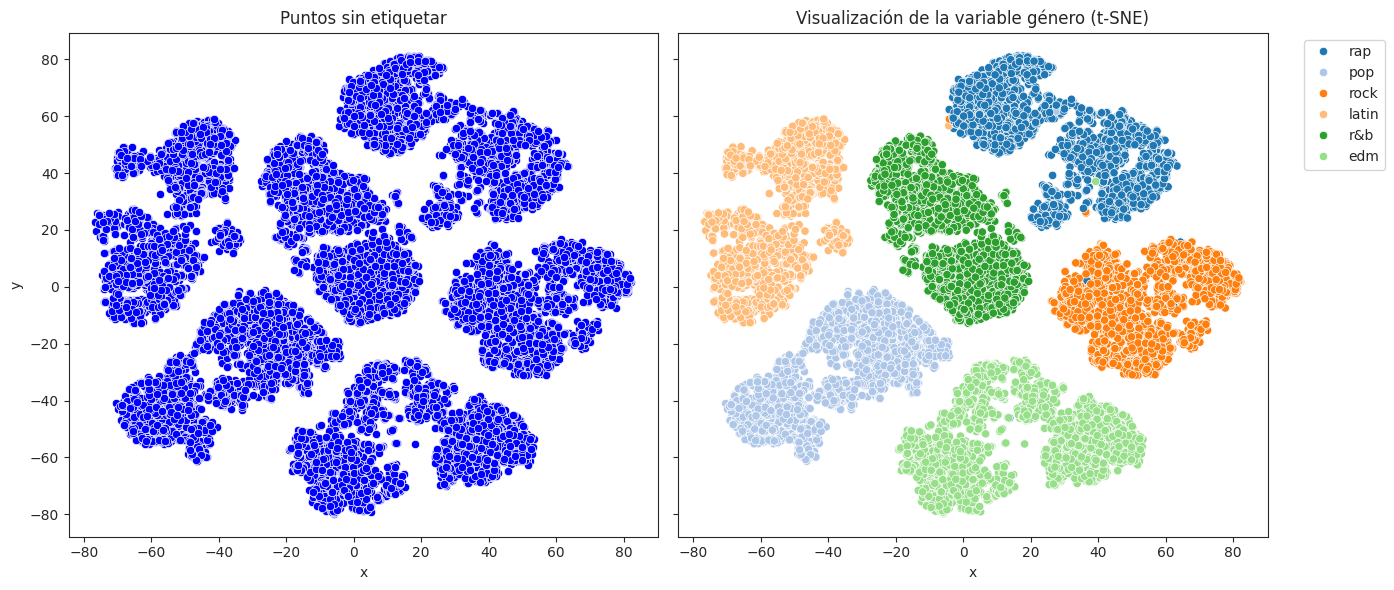

In [53]:
plot_result(df_etiq_subgeneros[['tsne1', 'tsne2']
                               ].values, df_etiq_subgeneros["playlist_genre"], title="Visualización de la variable género (t-SNE)")

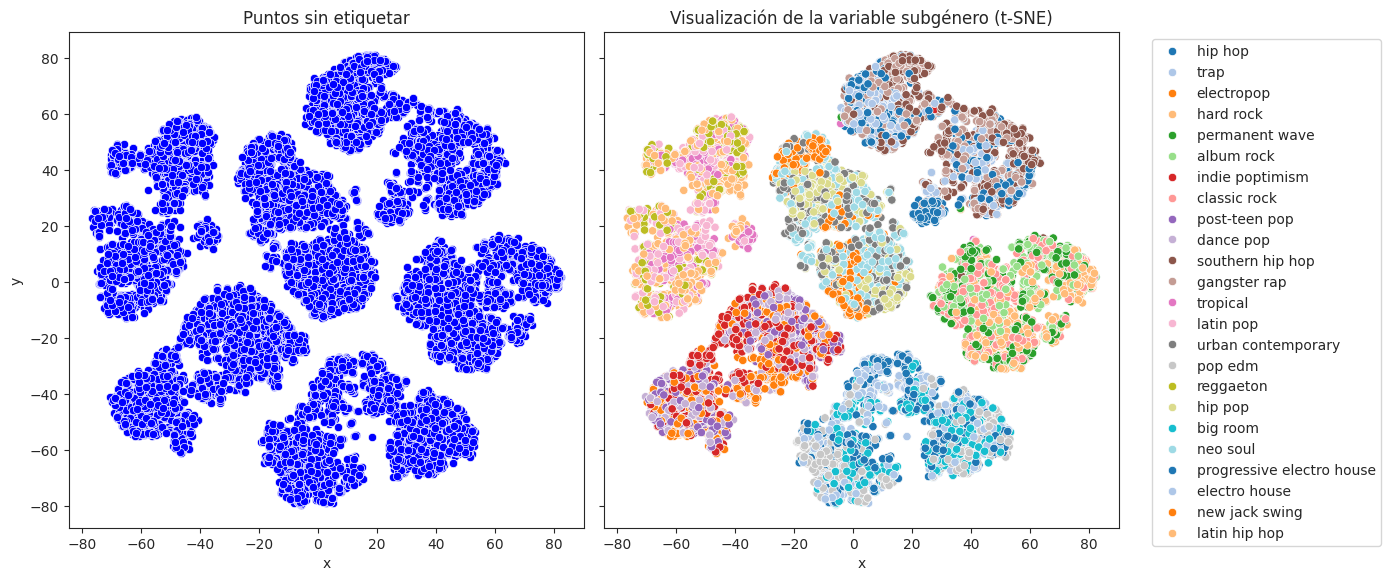

In [54]:
plot_result(df_etiq_subgeneros[['tsne1', 'tsne2']
                               ].values, df_etiq_subgeneros["playlist_subgenre"], title="Visualización de la variable subgénero (t-SNE)")

In [55]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

valores_puntos = [np.array(vec.values) for vec in df_results["value"]]

print("-------- Métricas para clustering --------")
print("Pseudo F: ", calinski_harabasz_score(
    valores_puntos, np.array(df_results["component"])))
print("Davies-Bouldin: ", davies_bouldin_score(valores_puntos,
      np.array(df_results["component"])))
print("Silueta: ", silhouette_score(valores_puntos,
      np.array(df_results["component"])))

-------- Métricas para clustering --------
Pseudo F:  600.6056145890411
Davies-Bouldin:  2.4530691873564328
Silueta:  -0.07982979615141457


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fa435b-89c8-4b22-a4df-60f2ff3508a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>